In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt # Visualization
import warnings # Supress warnings
import os
import random
warnings.filterwarnings('ignore')

In [3]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model

In [4]:
# Seed value
SEED = 2023
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(SEED)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [95]:
df = pd.read_csv("./files/cycl_m.csv", index_col=0)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')
df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry,year,month,quarter,season,month_sin,month_cos,quarter_sin,quarter_cos,season_sin,season_cos
Date,,,,,,,,,,,,,,,
2009-01-31,0.032915,0.216100,0.068714,0.726750,0.396506,2009,1,1,1,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2009-02-28,0.073145,0.296982,0.074975,0.936674,0.508567,2009,2,1,1,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2009-03-31,0.178683,0.356360,0.236094,0.627008,0.469107,2009,3,1,2,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17,1.224647e-16,-1.000000e+00
2009-04-30,0.085162,0.410094,0.413676,0.693265,0.407926,2009,4,2,2,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00
2009-05-31,0.149425,0.428197,0.647873,0.400633,0.201392,2009,5,2,2,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29,0.097179,0.583554,0.225748,0.736863,0.420133,2020,2,1,1,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2020-03-31,0.366771,0.605731,0.255726,0.721515,0.632459,2020,3,1,2,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17,1.224647e-16,-1.000000e+00
2020-04-30,0.217346,0.615560,0.421868,0.896287,0.475913,2020,4,2,2,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00


In [96]:
features_sin = ['Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry', 'day_sin', 'month_sin', 'week_of_year_sin', 'quarter_sin', 'season_sin']
features_cos = ['Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry', 'day_cos', 'month_cos', 'week_of_year_cos', 'quarter_cos', 'season_cos']
delete1 = [feature for feature in df.columns if feature not in features_sin]
delete2 = [feature for feature in df.columns if feature not in features_cos]

In [97]:
df_sin = df.drop(delete1, axis=1)
df_cos = df.drop(delete2, axis=1)

In [98]:
df_cos

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry,month_cos,quarter_cos,season_cos
Date,,,,,,,,
2009-01-31,0.032915,0.216100,0.068714,0.726750,0.396506,8.660254e-01,6.123234e-17,6.123234e-17
2009-02-28,0.073145,0.296982,0.074975,0.936674,0.508567,5.000000e-01,6.123234e-17,6.123234e-17
2009-03-31,0.178683,0.356360,0.236094,0.627008,0.469107,6.123234e-17,6.123234e-17,-1.000000e+00
2009-04-30,0.085162,0.410094,0.413676,0.693265,0.407926,-5.000000e-01,-1.000000e+00,-1.000000e+00
2009-05-31,0.149425,0.428197,0.647873,0.400633,0.201392,-8.660254e-01,-1.000000e+00,-1.000000e+00
...,...,...,...,...,...,...,...,...
2020-02-29,0.097179,0.583554,0.225748,0.736863,0.420133,5.000000e-01,6.123234e-17,6.123234e-17
2020-03-31,0.366771,0.605731,0.255726,0.721515,0.632459,6.123234e-17,6.123234e-17,-1.000000e+00
2020-04-30,0.217346,0.615560,0.421868,0.896287,0.475913,-5.000000e-01,-1.000000e+00,-1.000000e+00


In [99]:
features_new = ['Depth_to_Groundwater', 'Drainage_Volume', 'River_Hydrometry', 'month_cos', 'week_of_year_cos', 'quarter_cos']
features_3 = ['Rainfall', 'Depth_to_Groundwater', 'Drainage_Volume', 'River_Hydrometry', 'month_cos', 'quarter_cos']
delete3 = [feature for feature in df_cos.columns if feature not in features_3]
df_new = df_cos.drop(delete3, axis=1)

In [100]:
df = df_new
df

,Rainfall,Depth_to_Groundwater,Drainage_Volume,River_Hydrometry,month_cos,quarter_cos
Date,,,,,,
2009-01-31,0.032915,0.216100,0.726750,0.396506,8.660254e-01,6.123234e-17
2009-02-28,0.073145,0.296982,0.936674,0.508567,5.000000e-01,6.123234e-17
2009-03-31,0.178683,0.356360,0.627008,0.469107,6.123234e-17,6.123234e-17
2009-04-30,0.085162,0.410094,0.693265,0.407926,-5.000000e-01,-1.000000e+00
2009-05-31,0.149425,0.428197,0.400633,0.201392,-8.660254e-01,-1.000000e+00
...,...,...,...,...,...,...
2020-02-29,0.097179,0.583554,0.736863,0.420133,5.000000e-01,6.123234e-17
2020-03-31,0.366771,0.605731,0.721515,0.632459,6.123234e-17,6.123234e-17
2020-04-30,0.217346,0.615560,0.896287,0.475913,-5.000000e-01,-1.000000e+00


In [101]:
N_FEATURES  = 6 # multivariate
N_STEPS_IN  = 5 # static window
N_STEPS_OUT = 1  # single-step
TRAIN_SIZE = int((len(df.index)-N_STEPS_IN) * 0.5)
VAL_SIZE = int((len(df.index)-N_STEPS_IN) * 0.2)
#print(TRAIN_SIZE, VAL_SIZE)

In [102]:
def df_to_X_y(df):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-N_STEPS_IN):
        row = [r for r in df_as_np[i:i+N_STEPS_IN]]
        X.append(row)
        label = df_as_np[i+N_STEPS_IN][1]
        y.append(label)
    return np.array(X), np.array(y)

In [103]:
X1, y1=df_to_X_y(df)
X1.shape, y1.shape

((133, 5, 6), (133,))

In [104]:
def get_sets(df):
    X1, y1 = df_to_X_y(df)
    X_train1, y_train1 = X1[:TRAIN_SIZE], y1[:TRAIN_SIZE]
    X_val1, y_val1 = X1[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE], y1[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE]
    X_test1, y_test1 = X1[TRAIN_SIZE + VAL_SIZE:], y1[TRAIN_SIZE + VAL_SIZE:]
    return X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1

In [105]:
X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = get_sets(df)
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((66, 5, 6), (66,), (26, 5, 6), (26,), (41, 5, 6), (41,))

In [106]:
def init_model(lstm_units = 64, lstm_units_sec = 64):
    # Use initializers to initialize model parameters with the same values
    INITIALIZER_GLOROT_UNIFORM = tf.keras.initializers.GlorotUniform(seed = SEED)
    INITIALIZER_ORTHOGONAL = tf.keras.initializers.Orthogonal(gain = 1.0, seed = SEED)
    model = Sequential()
    model.add(InputLayer((N_STEPS_IN, N_FEATURES)))
    # model.add(LSTM(units                 = lstm_units,
    #                kernel_initializer    = INITIALIZER_GLOROT_UNIFORM,
    #                recurrent_initializer = INITIALIZER_ORTHOGONAL,
    #                return_sequences=True))
    model.add(LSTM(units                 = lstm_units_sec,
                   kernel_initializer    = INITIALIZER_GLOROT_UNIFORM,
                   recurrent_initializer = INITIALIZER_ORTHOGONAL))
    tf.keras.layers.Dropout(0.3),
    model.add(Dense(units= 8, activation='relu', kernel_initializer = INITIALIZER_GLOROT_UNIFORM))
    model.add(Dense(units              = N_STEPS_OUT,
                    kernel_initializer = INITIALIZER_GLOROT_UNIFORM,
                    activation = 'linear'))
    model.summary()
    return model

In [107]:
# Create model instance
model = init_model()

# Visualize model architecture
#tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                18176     
                                                                 
 dense_18 (Dense)            (None, 8)                 520       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [109]:
def train_model(df, checkpoint):
    X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = get_sets(df)
    model = init_model()
    cp = ModelCheckpoint('C:\\Users\\poeppelmann\\DataspellProjects\\dsProject\\LSTM_models\\multi\\'+checkpoint, save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer='adam', metrics=[RootMeanSquaredError()])
    model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp])
    return model

In [110]:
def model_predict(df, checkpoint):
    model = load_model('C:\\Users\\poeppelmann\\DataspellProjects\\dsProject\\LSTM_models\\multi\\'+checkpoint)
    X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = get_sets(df)
    #train_predictions = model.predict(X_train1).flatten()
    #val_predictions = model.predict(X_val1).flatten()
    #predictions = np.concatenate((train_predictions, val_predictions, test_predictions))
    #results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y1}, index=df.index[5:])
    #results.to_csv('predictions/'+name)
    predictions = pd.Series(model.predict(X_test1).flatten())
    predictions.index = df.index[TRAIN_SIZE+VAL_SIZE+N_STEPS_IN:]
    predictions.name='Depth_to_Groundwater'
    return predictions

In [111]:
checkpoint = '6'

In [112]:
train_model(df, checkpoint)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                18176     
                                                                 
 dense_20 (Dense)            (None, 8)                 520       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/3 [=========>....................] - ETA: 8s - loss: 0.3730 - root_mean_squared_error: 0.6107

INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


3/3 [==============================] - 16s 6s/step - loss: 0.3679 - root_mean_squared_error: 0.6065 - val_loss: 0.4502 - val_root_mean_squared_error: 0.6710
Epoch 2/50
1/3 [=========>....................] - ETA: 0s - loss: 0.2733 - root_mean_squared_error: 0.5228

INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


3/3 [==============================] - 13s 7s/step - loss: 0.2773 - root_mean_squared_error: 0.5266 - val_loss: 0.2811 - val_root_mean_squared_error: 0.5302
Epoch 3/50
1/3 [=========>....................] - ETA: 0s - loss: 0.2110 - root_mean_squared_error: 0.4593

INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


3/3 [==============================] - 11s 5s/step - loss: 0.1873 - root_mean_squared_error: 0.4327 - val_loss: 0.1438 - val_root_mean_squared_error: 0.3792
Epoch 4/50
1/3 [=========>....................] - ETA: 0s - loss: 0.1425 - root_mean_squared_error: 0.3775

INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


3/3 [==============================] - 9s 5s/step - loss: 0.1089 - root_mean_squared_error: 0.3300 - val_loss: 0.0499 - val_root_mean_squared_error: 0.2234
Epoch 5/50
1/3 [=========>....................] - ETA: 0s - loss: 0.0720 - root_mean_squared_error: 0.2683

INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


3/3 [==============================] - 10s 5s/step - loss: 0.0536 - root_mean_squared_error: 0.2315 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 6/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1269
Epoch 7/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.0529 - val_root_mean_squared_error: 0.2300
Epoch 8/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0266 - root_mean_squared_error: 0.1630 - val_loss: 0.0759 - val_root_mean_squared_error: 0.2755
Epoch 9/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0302 - root_mean_squared_error: 0.1738 - val_loss: 0.0663 - val_root_mean_squared_error: 0.2575
Epoch 10/50
3/3 [==============================] - 0s 23ms/step - loss: 0.0241 - root_mean_squared_error: 0.1554 - val_loss: 0.0426 - val_root_mean_squared_error: 0.20

INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


3/3 [==============================] - 10s 5s/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 14/50
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1053

INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


INFO:tensorflow:Assets written to: C:\Users\poeppelmann\DataspellProjects\dsProject\LSTM_models\multi\6\assets


3/3 [==============================] - 8s 4s/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0765
Epoch 15/50
3/3 [==============================] - 0s 18ms/step - loss: 0.0119 - root_mean_squared_error: 0.1089 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 16/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 17/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1512
Epoch 18/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1776
Epoch 19/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.0337 - val_root_mean_squared_error: 0

In [113]:
result = model_predict(df, checkpoint)

2/2 [==============================] - 0s 2ms/step


In [114]:
result

Date
2017-02-28    0.782112
2017-03-31    0.796726
2017-04-30    0.816397
2017-05-31    0.789760
2017-06-30    0.762467
2017-07-31    0.696065
2017-08-31    0.595710
2017-09-30    0.509507
2017-10-31    0.504665
2017-11-30    0.518082
2017-12-31    0.576791
2018-01-31    0.633805
2018-02-28    0.651584
2018-03-31    0.671002
2018-04-30    0.743130
2018-05-31    0.739050
2018-06-30    0.723745
2018-07-31    0.693301
2018-08-31    0.622243
2018-09-30    0.552507
2018-10-31    0.520980
2018-11-30    0.579371
2018-12-31    0.618838
2019-01-31    0.645541
2019-02-28    0.657154
2019-03-31    0.665683
2019-04-30    0.668622
2019-05-31    0.656400
2019-06-30    0.671276
2019-07-31    0.626961
2019-08-31    0.595801
2019-09-30    0.552220
2019-10-31    0.528305
2019-11-30    0.542248
2019-12-31    0.623958
2020-01-31    0.658274
2020-02-29    0.670240
2020-03-31    0.671090
2020-04-30    0.700463
2020-05-31    0.666410
2020-06-30    0.631691
Name: Depth_to_Groundwater, dtype: float32

In [115]:
result.to_csv('predictions/LSTM_multi/'+checkpoint+'.csv')

In [116]:
metrics = {}
def calc_metrics(name, series):

    results = pd.DataFrame(data={'Predictions':series, 'Actuals':df[name]}, index=series.index)

    # Step 2: Calculate the differences between the predicted and actual values
    results['Difference'] = results['Actuals'] - results['Predictions']

    # Step 3: Calculate squared differences for RMSE
    results['Squared_difference'] = results['Difference'] ** 2

    # Step 4: Calculate absolute differences for MAE and MAPE
    results['Absolute_difference'] = np.abs(results['Difference'])
    results['Absolute_percentage_difference'] = np.abs(results['Difference'] / results['Actuals'])

    # Step 5: Compute the metrics
    rmse = np.sqrt(results['Squared_difference'].mean())
    mae = results['Absolute_difference'].mean()
    mape = results['Absolute_percentage_difference'].mean() * 100  # to get the percentage
    return rmse, mae, mape

column = 'Depth_to_Groundwater'
rmse, mae, mape = calc_metrics(column, result)
metrics[column] = {
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}
metrics_df = pd.DataFrame(metrics)

In [117]:
metrics_df

,Depth_to_Groundwater
MAE,0.081895
MAPE,15.167235
RMSE,0.093202


In [91]:
metrics_df.to_csv('metrics/LSTM_multi/'+checkpoint+'.csv')

<Axes: xlabel='Date'>

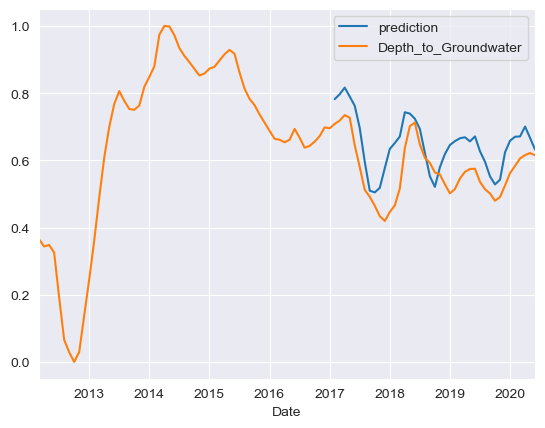

In [94]:
result[-100:].plot(legend=True, label='prediction')
df['Depth_to_Groundwater'][-100:].plot(legend=True)

In [118]:
import winsound
winsound.Beep(2500,1000)